<a href="https://colab.research.google.com/github/Davydmunoz0/winequality-red/blob/main/winequality_red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2025-04-03 01:13:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘winequality-red.csv’

winequality-red.csv     [ <=>                ]  82.23K  --.-KB/s    in 0.1s    

2025-04-03 01:13:47 (564 KB/s) - ‘winequality-red.csv’ saved [84199]

Distribuição das classes:
target
0    1382
1     217
Name: count, dtype: int64


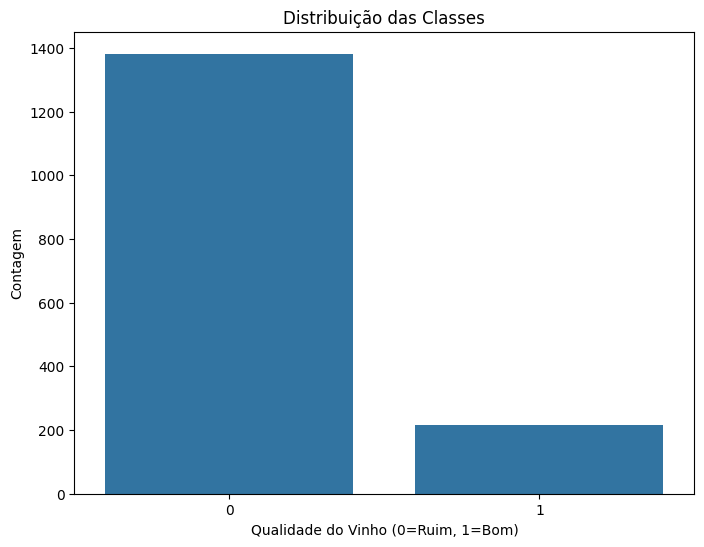


Cross-validation scores: [0.91855204 0.90950226 0.88235294 0.88461538 0.8800905 ]
Mean CV accuracy: 89.50%
Standard deviation: 1.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       277
           1       0.57      0.67      0.62        43

    accuracy                           0.89       320
   macro avg       0.76      0.80      0.78       320
weighted avg       0.90      0.89      0.89       320



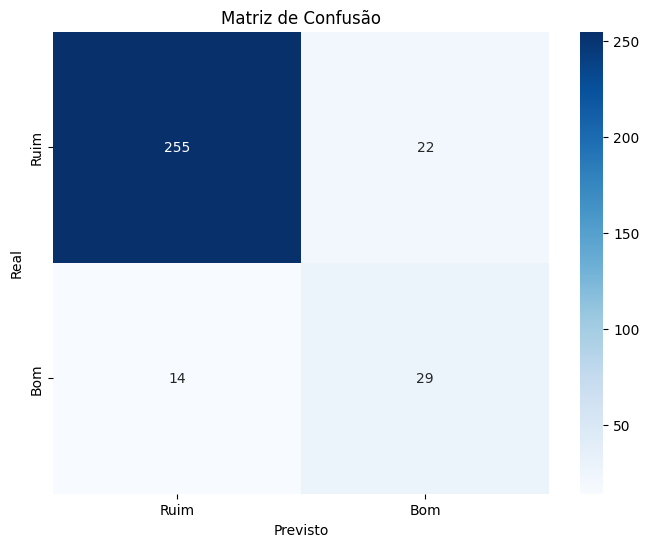

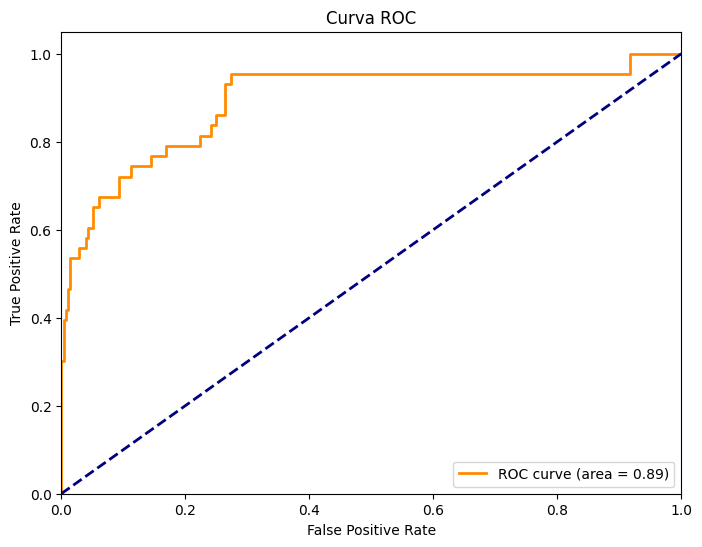


AUC-ROC: 0.89


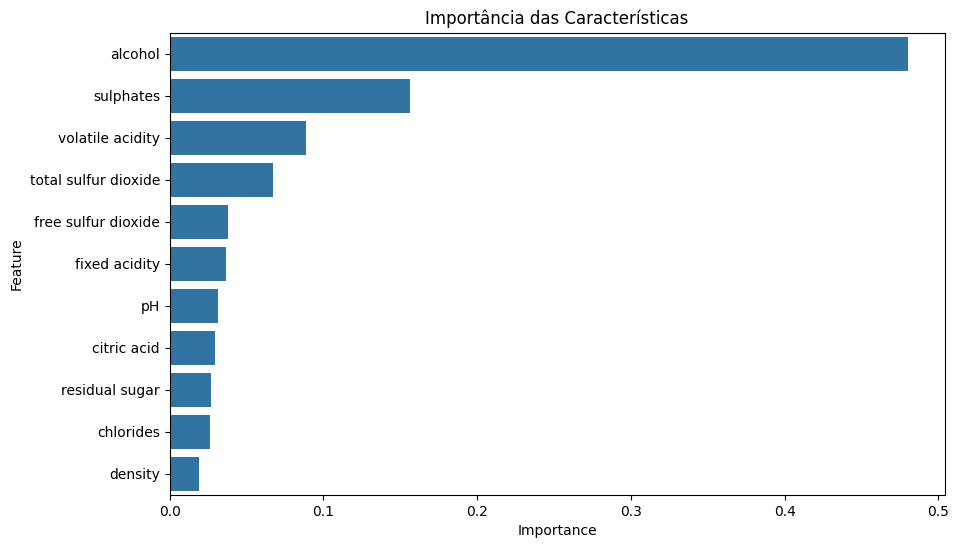


Previsão Manual de Qualidade do Vinho
Por favor, insira os valores para as seguintes características:
Acidez fixa (g/dm³): 22
Acidez volátil (g/dm³): 22
Ácido cítrico (g/dm³): 22
Açúcar residual (g/dm³): 22
Cloretos (g/dm³): 22
Dióxido de enxofre livre (mg/dm³): 22
Dióxido de enxofre total (mg/dm³): 22
Densidade (g/cm³): 22
pH: 22
Sulfatos (g/dm³): 22
Álcool (% vol): 22

Resultado da Previsão:
O vinho é previsto como RUIM (qualidade < 7)
Probabilidade de ser um vinho bom: 43.13%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the dataset
# Try providing the full path to the file or make sure it is in the same directory
# as your notebook/script. You can also download the dataset using the command below:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
df = pd.read_csv('winequality-red.csv', sep=';')
# ... rest of your code ...

# Define target variable (binary classification: good/bad wine)
df['target'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Separate features and target
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

# Check class distribution
print("Distribuição das classes:")
print(y.value_counts())

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribuição das Classes')
plt.xlabel('Qualidade do Vinho (0=Ruim, 1=Bom)')
plt.ylabel('Contagem')
plt.show()

# Stratified train-test split (maintains class proportions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Cross-validation with StratifiedKFold (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gb_model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')

print("\nCross-validation scores:", cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))
print("Standard deviation: {:.2f}%".format(cv_scores.std() * 100))

# Train the model on full training data
gb_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = gb_model.predict(X_test_scaled)
y_pred_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ruim', 'Bom'],
            yticklabels=['Ruim', 'Bom'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print("\nAUC-ROC: {:.2f}".format(roc_auc))

# Feature Importance
feature_importance = gb_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Características')
plt.show()

# Function for manual prediction
def prever_manual():
    print("\nPrevisão Manual de Qualidade do Vinho")
    print("Por favor, insira os valores para as seguintes características:")

    fixed_acidity = float(input("Acidez fixa (g/dm³): "))
    volatile_acidity = float(input("Acidez volátil (g/dm³): "))
    citric_acid = float(input("Ácido cítrico (g/dm³): "))
    residual_sugar = float(input("Açúcar residual (g/dm³): "))
    chlorides = float(input("Cloretos (g/dm³): "))
    free_sulfur_dioxide = float(input("Dióxido de enxofre livre (mg/dm³): "))
    total_sulfur_dioxide = float(input("Dióxido de enxofre total (mg/dm³): "))
    density = float(input("Densidade (g/cm³): "))
    pH = float(input("pH: "))
    sulphates = float(input("Sulfatos (g/dm³): "))
    alcohol = float(input("Álcool (% vol): "))

    # Create input array
    input_data = np.array([[fixed_acidity, volatile_acidity, citric_acid, residual_sugar,
                           chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density,
                           pH, sulphates, alcohol]])

    # Scale the input
    input_scaled = scaler.transform(input_data)

    # Make prediction
    prediction = gb_model.predict(input_scaled)
    probability = gb_model.predict_proba(input_scaled)[0][1]

    print("\nResultado da Previsão:")
    if prediction[0] == 1:
        print("O vinho é previsto como BOM (qualidade ≥ 7)")
    else:
        print("O vinho é previsto como RUIM (qualidade < 7)")

    print(f"Probabilidade de ser um vinho bom: {probability*100:.2f}%")

# Call the prediction function
prever_manual()